# Imports

In [1]:
from library.dataPreprocessLib import *
from library.resultsLib import *
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import os

# Data Preprocessing

## Feature Selection and Loading Data

In [2]:
# name = "prantika_bus_stand"
# name = "junction_mall"
name = "54ft_road"
# name = "dvc_more"
# name = "station"

In [3]:
parent_dir = r"../data/54ft/"
train_df_name = r"54ft_train.csv"
test_df_name = f"{name}_test_split.csv"

In [4]:
poi_column = 'Is_Adhoc'
output_result_filename = f"{poi_column}_test_result_{name}_zone.csv"

In [5]:
#feature # binding
F=\
    {1:'stay_duration', #f1
     2:'mfcc0',3:'mfcc1',4:'mfcc2',5:'mfcc3',6:'mfcc4', #f2,f3,f4,f5,f6
     7:'wifi_count', 8:'edge_wifi_count', #f7,f8
     9:'RSI', #f9
     10:'human_made', 11:'natural_land',12:'road_exist_percent',13:'highly_populated_poi_exist'#f10,f11,f12,f13
    }



feature_names=[F[e] for e in [10,12,11,1,8]]

### Training Data

In [6]:
train_csv_df = pd.read_csv(os.path.join(parent_dir, train_df_name))
train_df = train_csv_df[feature_names+[poi_column]]
train_df.head()

,human_made,road_exist_percent,natural_land,stay_duration,edge_wifi_count,Is_Adhoc
0,0.111232,0.251963,0.636805,6,0.000000,1
1,0.124869,0.208544,0.666587,10,0.015468,0
2,0.100360,0.155972,0.743668,130,0.027800,0
3,0.100911,0.169076,0.730013,13,0.000000,1
4,0.117394,0.183064,0.487688,9,0.002818,0


### Testing Data

In [7]:
test_csv_df = pd.read_csv(os.path.join(parent_dir, test_df_name))
test_df = test_csv_df[feature_names+[poi_column]]
test_df.head()

,human_made,road_exist_percent,natural_land,stay_duration,edge_wifi_count,Is_Adhoc
0,0.228177,0.271135,0.500080,11,0.011578,0
1,0.200089,0.268251,0.459261,2,0.000000,1
2,0.254925,0.285081,0.459994,8,0.037472,1
3,0.218173,0.270912,0.510915,8,0.047988,0
4,0.228172,0.277140,0.489662,13,0.036448,0


### Seperating target column and input columns

In [8]:
X = train_df[feature_names].copy()
y = train_df[poi_column].copy()

## Using SMOTE

In [9]:
smote = SMOTE()

In [10]:
X_resampled, y_resampled = smote.fit_sample(X, y)
print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(2480, 5)
(2480,)
(2942, 5)
(2942,)


## Categorical data Transformation

### For train data

In [11]:
train_data = X_resampled.copy()
train_labels = y_resampled.copy()

### For test data

In [12]:
test_data = test_df[feature_names].values
test_labels = test_df[poi_column].values

# Training

In [13]:
model = RandomForestClassifier(n_estimators=20,max_depth=8)
model.fit(train_data, train_labels)
train_predictions = model.predict(train_data) # for training performance stat

# Testing

In [14]:
assert test_data.shape[1] == train_data.shape[1], "Train and Test Data shape mismatch"
test_predictions = model.predict(test_data)

# Performance Stat

## Training Performance

In [15]:
get_performance_stats("train", train_labels, train_predictions)

For train: 
	Accuracy: 0.8755948334466349
	Precision: 0.8760647751623335
	Recall: 0.8755948334466349
	F1 score: 0.8755559562030635
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1471
           1       0.89      0.86      0.87      1471

    accuracy                           0.88      2942
   macro avg       0.88      0.88      0.88      2942
weighted avg       0.88      0.88      0.88      2942



## Testing Performance

In [16]:
get_performance_stats("test", test_labels, test_predictions)

For test: 
	Accuracy: 0.7551020408163265
	Precision: 0.8283564261825133
	Recall: 0.7551020408163265
	F1 score: 0.7668206848534718
              precision    recall  f1-score   support

           0       0.94      0.70      0.80        70
           1       0.54      0.89      0.68        28

    accuracy                           0.76        98
   macro avg       0.74      0.80      0.74        98
weighted avg       0.83      0.76      0.77        98



### Confusion Matrix

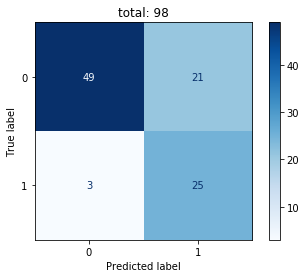

In [18]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(model, test_data, test_labels, cmap=plt.cm.Blues)
disp.ax_.set_title(f'total: {len(test_data)}')
plt.show()

### Check & Save Predicitons

In [19]:
result_df = form_result_df(test_csv_df, test_predictions, poi_column)
result_df.head()

,instance_date,instance_start_time,instance_end_time,Prediction Is_Adhoc
0,09/14/2019,12:36:15,12:36:26,0
1,09/14/2019,12:36:38,12:36:39,1
2,09/14/2019,17:16:49,17:16:56,1
3,09/14/2019,17:17:33,17:17:40,1
4,09/14/2019,17:18:04,17:18:19,0


In [20]:
result_df.to_csv(os.path.join(parent_dir, output_result_filename), index=False)

In [21]:
test_labels

array([0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0], dtype=int64)

In [22]:
test_predictions

array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1], dtype=int64)